In [1]:
import argparse
import torch
import numpy as np
import random
import os 
from model import BaselineModel
from dataloader import *
from train_utils import train_baseline, train_coral, train_adversarial, train_adabn
from plot_utils import *

%load_ext autoreload
%autoreload 2


In [2]:
class Trainer:
    def __init__(self, args, device):
        self.args = args
        self.device = device
        self.source_loader, self.target_loader = prepare_data(batch_size=args.batch_size)

    def train_baseline(self):
        model = BaselineModel().to(self.device)
        return train_baseline(model, self.source_loader, self.target_loader, 
                            self.args, self.device)

    def train_coral(self):
        model = BaselineModel().to(self.device)
        return train_coral(model, self.source_loader, self.target_loader, 
                          self.args, self.device)

    def train_adversarial(self):
        model = BaselineModel().to(self.device)
        return train_adversarial(model, self.source_loader, self.target_loader, 
                               self.args, self.device)

    def train_adabn(self):
        model = BaselineModel().to(self.device)
        return train_adabn(model, self.source_loader, self.target_loader, 
                          self.args, self.device)



def main(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    set_seed(args.seed)
    trainer = Trainer(args, device)
    
    results = {}
    
    if args.method == 'baseline' or args.method == 'all':
        results['baseline'] = trainer.train_baseline()
    
    if args.method == 'coral' or args.method == 'all':
        results['coral'] = trainer.train_coral()
    
    if args.method == 'adversarial' or args.method == 'all':
        results['adversarial'] = trainer.train_adversarial()
    
    if args.method == 'adabn' or args.method == 'all':
        results['adabn'] = trainer.train_adabn()
    
    print("\nFinal Target Accuracies:")
    for model_name, model_results in results.items():
        print(f"{model_name}: {model_results['final_target_acc']:.4f}")
    
    # Save results with timestamp
    import pickle
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs('results', exist_ok=True)
    with open(f'results/results_{timestamp}.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    return results


# For notebook usage
parser = argparse.ArgumentParser(description='Domain Adaptation Methods')
parser.add_argument('--method', type=str, default='all',
                    choices=['baseline', 'coral', 'adversarial', 'adabn', 'all'])
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--coral_weight', type=float, default=1.0)
parser.add_argument('--adversarial_weight', type=float, default=1.0)
args = parser.parse_args([]) 

results = main(args)

Using device: cpu

Training Baseline Model...


Epoch 10/100: 100%|██████████| 7/7 [00:00<00:00, 30.17it/s]



Epoch: 10/100
Training Loss: 0.3865 | Accuracies: Source = 1.0000, Target = 0.8400


Epoch 20/100: 100%|██████████| 7/7 [00:00<00:00, 31.53it/s]



Epoch: 20/100
Training Loss: 0.1314 | Accuracies: Source = 1.0000, Target = 0.7950


Epoch 30/100: 100%|██████████| 7/7 [00:00<00:00, 34.77it/s]



Epoch: 30/100
Training Loss: 0.0721 | Accuracies: Source = 1.0000, Target = 0.8000


Epoch 40/100: 100%|██████████| 7/7 [00:00<00:00, 37.70it/s]



Epoch: 40/100
Training Loss: 0.0555 | Accuracies: Source = 1.0000, Target = 0.8000


Epoch 50/100: 100%|██████████| 7/7 [00:00<00:00, 41.66it/s]



Epoch: 50/100
Training Loss: 0.0373 | Accuracies: Source = 1.0000, Target = 0.8000


Epoch 60/100: 100%|██████████| 7/7 [00:00<00:00, 53.65it/s]



Epoch: 60/100
Training Loss: 0.0290 | Accuracies: Source = 1.0000, Target = 0.8000


Epoch 70/100: 100%|██████████| 7/7 [00:00<00:00, 45.54it/s]



Epoch: 70/100
Training Loss: 0.0260 | Accuracies: Source = 1.0000, Target = 0.8000


Epoch 80/100: 100%|██████████| 7/7 [00:00<00:00, 34.81it/s]



Epoch: 80/100
Training Loss: 0.0219 | Accuracies: Source = 1.0000, Target = 0.8000


Epoch 90/100: 100%|██████████| 7/7 [00:00<00:00, 48.66it/s]



Epoch: 90/100
Training Loss: 0.0167 | Accuracies: Source = 1.0000, Target = 0.8000


Epoch 100/100: 100%|██████████| 7/7 [00:00<00:00, 34.39it/s]



Epoch: 100/100
Training Loss: 0.0177 | Accuracies: Source = 1.0000, Target = 0.8000

Training CORAL Model...

Epoch: 10/100
Training Loss: 1.1836 | Accuracies: Source = 0.9150, Target = 0.6300

Epoch: 20/100
Training Loss: 0.6854 | Accuracies: Source = 0.9900, Target = 0.7200

Epoch: 30/100
Training Loss: 0.5007 | Accuracies: Source = 0.9850, Target = 0.6900

Epoch: 40/100
Training Loss: 0.3707 | Accuracies: Source = 1.0000, Target = 0.8000

Epoch: 50/100
Training Loss: 0.3011 | Accuracies: Source = 1.0000, Target = 0.8200

Epoch: 60/100
Training Loss: 0.2128 | Accuracies: Source = 1.0000, Target = 0.8900

Epoch: 70/100
Training Loss: 0.2262 | Accuracies: Source = 1.0000, Target = 0.8900

Epoch: 80/100
Training Loss: 0.2163 | Accuracies: Source = 1.0000, Target = 0.8950

Epoch: 90/100
Training Loss: 0.1781 | Accuracies: Source = 1.0000, Target = 0.8850

Epoch: 100/100
Training Loss: 0.1407 | Accuracies: Source = 1.0000, Target = 0.8950

Training Adversarial Model...

Epoch: 10/100
Tra

Epoch 10 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 52.42it/s]



Epoch: 10/100
Training Loss: 0.3485
Source Accuracy: 1.0000
Target Accuracy: 0.7400


Epoch 20 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 54.35it/s]



Epoch: 20/100
Training Loss: 0.1190
Source Accuracy: 1.0000
Target Accuracy: 0.7800


Epoch 30 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 53.87it/s]



Epoch: 30/100
Training Loss: 0.0994
Source Accuracy: 1.0000
Target Accuracy: 0.8000


Epoch 40 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 52.45it/s]



Epoch: 40/100
Training Loss: 0.0523
Source Accuracy: 1.0000
Target Accuracy: 0.8100


Epoch 50 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 51.13it/s]



Epoch: 50/100
Training Loss: 0.0377
Source Accuracy: 1.0000
Target Accuracy: 0.7600


Epoch 60 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 53.48it/s]



Epoch: 60/100
Training Loss: 0.0310
Source Accuracy: 1.0000
Target Accuracy: 0.7950


Epoch 70 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 55.99it/s]



Epoch: 70/100
Training Loss: 0.0277
Source Accuracy: 1.0000
Target Accuracy: 0.8050


Epoch 80 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 55.49it/s]



Epoch: 80/100
Training Loss: 0.0184
Source Accuracy: 1.0000
Target Accuracy: 0.7850


Epoch 90 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 48.35it/s]



Epoch: 90/100
Training Loss: 0.0224
Source Accuracy: 1.0000
Target Accuracy: 0.8150


Epoch 100 (Source Training): 100%|██████████| 7/7 [00:00<00:00, 52.72it/s]



Epoch: 100/100
Training Loss: 0.0146
Source Accuracy: 1.0000
Target Accuracy: 0.7800

Adapting BN statistics on target domain...

Final Target Accuracy after AdaBN: 0.9700

Final Target Accuracies:
baseline: 0.8000
coral: 0.8950
adversarial: 1.0000
adabn: 0.9700


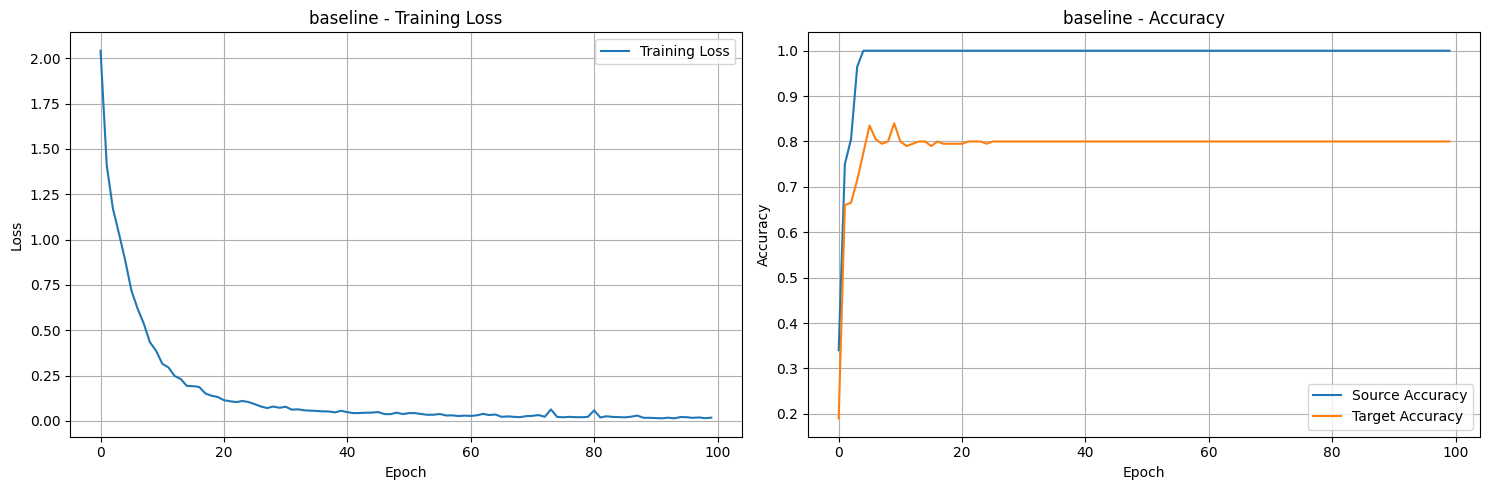

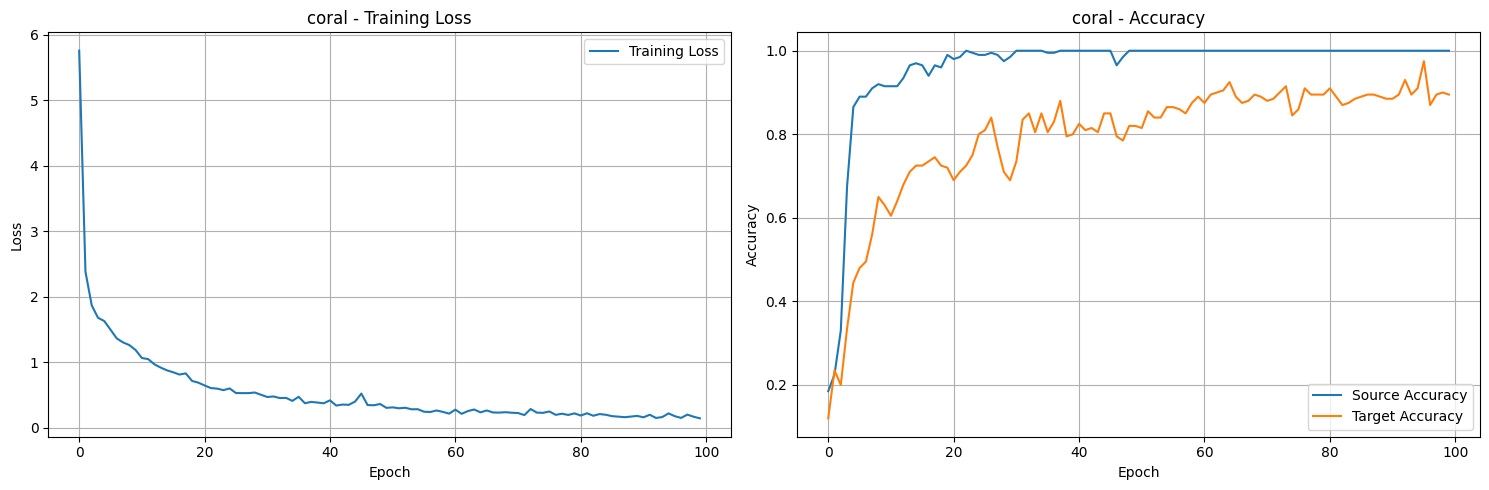

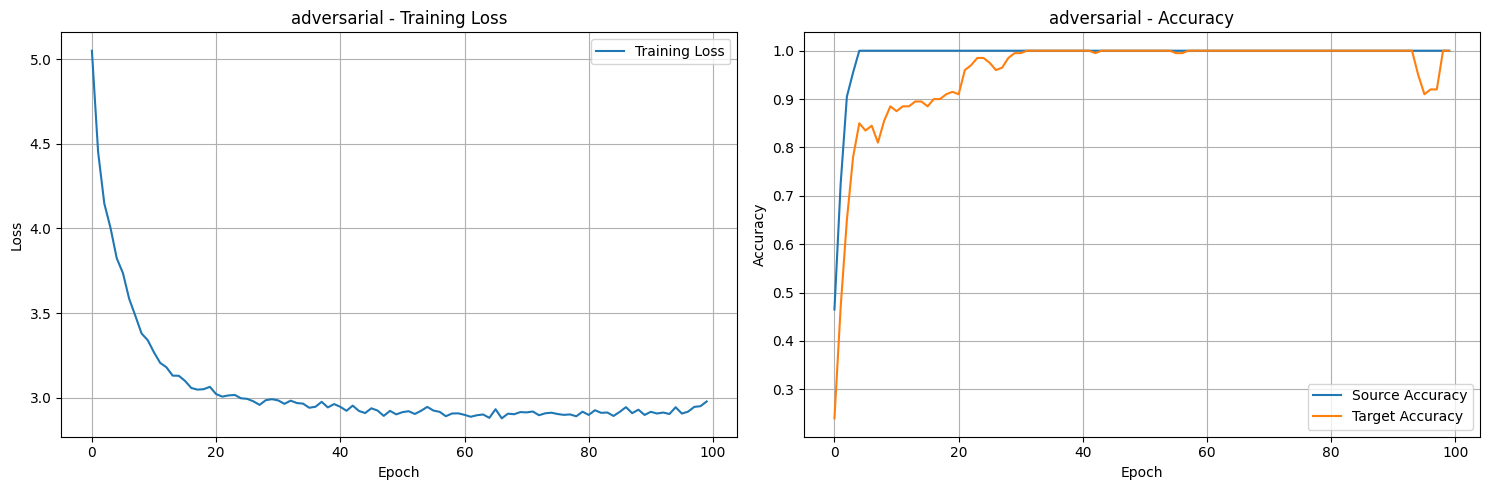

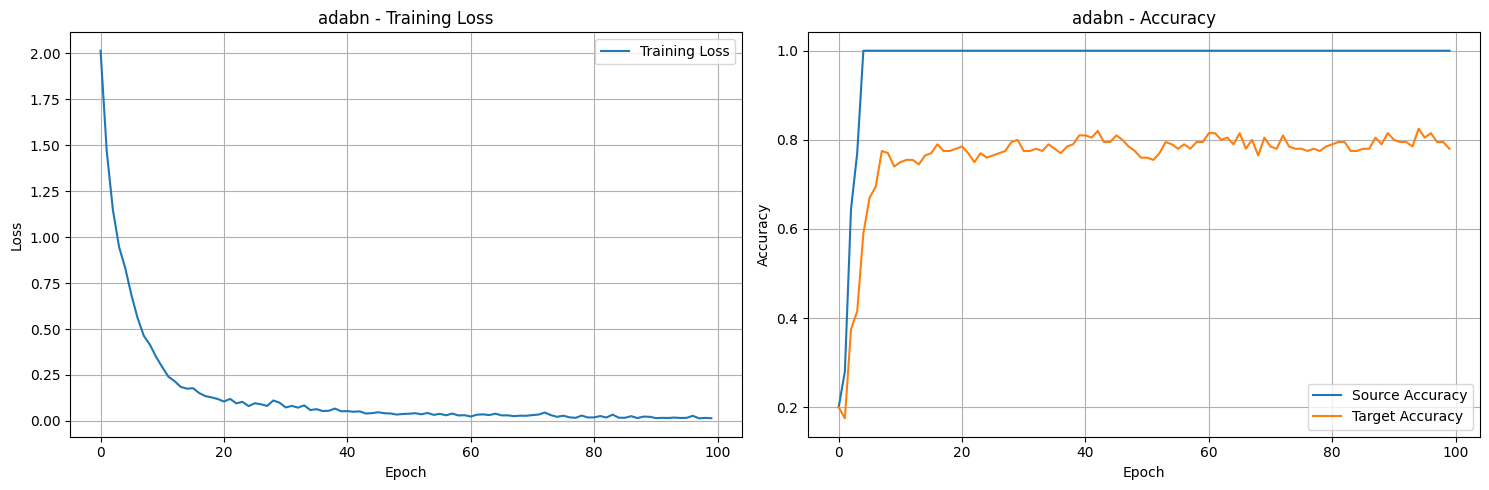

In [3]:
plot_training_curves(results, save=True, show=True)